In [2]:
import pandas as pd
import numpy as np

In [98]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score, balanced_accuracy_score, roc_curve

In [144]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
import enelvo
from enelvo.normaliser import Normaliser
import re
import unidecode

from collections import Counter
from mittens import GloVe, Mittens

[nltk_data] Downloading package punkt to /home/joao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [163]:
df = pd.read_csv("dataset.csv")

In [164]:
df.head(20)

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"
5,Na EAD Educação a distância você tem autonomia...,educação
6,Veja as condições de compra.,varejo
7,"Pensão por Morte (Art. 74/9), Benefícios em Es...",orgão público
8,A primeira agência foi aberta em 2 de janeiro ...,finanças
9,Valor das parcelas,"finanças,varejo"


<AxesSubplot:xlabel='category'>

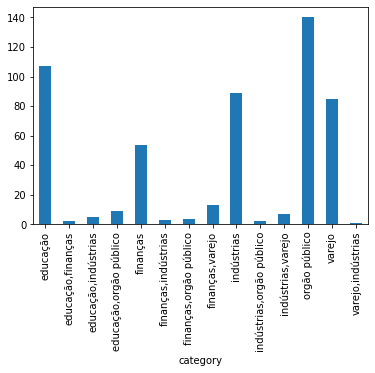

In [165]:
df.groupby(['category']).size().plot.bar()

# Pré-processamento

Vamos pré-processar os dados textuais, gerando um conjunto de dados mais "limpo" para alimentar o modelo. Serão removidas as strings que não são palavras, e todas as entradas serão transformadas em letras minúsculas. Além disso, a função normalise da biblioteca enelvo será utilizada para garantir que palavras potencialmente escritas em grafia não usual sejam transformadas para a ortografia padrão.

In [169]:
def pre_processamento(texto):
  
    texto_proc =  re.findall(r'\b[A-zÀ-úü]+\b', texto.lower())
    # remove stopwords
    stopwords = nltk.corpus.stopwords.words('portuguese')
    stop = set(stopwords)
    sem_stopwords = [w for w in texto_proc if w not in stop]

    # juntando os tokens novamente em formato de texto
    texto_limpo = " ".join(sem_stopwords)

    texto_proc = norm.normalise(texto_limpo)
    
    #texto_proc = unidecode.unidecode(texto_proc)
    

    return texto_proc

In [170]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
norm = Normaliser(tokenizer='readable')

[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
df.sentence = [pre_processamento(sentence) for sentence in df.sentence]

In [172]:
df.head()

,sentence,category
0,auxílio doença previdenciário benefícios espéc...,orgão público
1,pagar todas contas atraso ar,finanças
2,então encontraremos próxima aula,educação
3,veja resultados categoria ofertas novo modelo ...,indústrias
4,além disso embalagem reutilizável reciclável,"indústrias,varejo"


In [173]:
class2id = {
    "fin": 0,
    "edu": 1,
    "ind": 2,
    "var": 3,
    "org": 4
}

In [174]:
id2class = {
    0: "fin",
    1: "edu",
    2: "ind",
    3: "var",
    4: "org"
}

In [175]:
total = 0
for cat in df.category:
    if "," in cat:
        total += 1

print(total)
print(len(df.category))

46
521


In [176]:
df.category.value_counts()

orgão público               140
educação                    107
indústrias                   89
varejo                       85
finanças                     54
finanças,varejo              13
educação,orgão público        9
indústrias,varejo             7
educação,indústrias           5
finanças,orgão público        4
finanças,indústrias           3
indústrias,orgão público      2
educação,finanças             2
varejo,indústrias             1
Name: category, dtype: int64

Para tratar o fato do problema ser multilabel, vamos começar empregando a estratégia mais simples: vamos selecionar apenas uma das labels quando houverem duas. A label escolhida será aquela que, dentre as duas, menos aparece no dataset, de forma a favorecer o balanceamento.

In [177]:
label_priority = {
    "org": 5,
    "edu": 4,
    "ind": 3,
    "var": 2,
    "fin": 1
}

def select_label (l1, l2):
    if label_priority[l1] < label_priority[l2]:
        return l1
    return l2


In [178]:
select_label("org", "fin")

'fin'

In [179]:
df.category = [cat.split(',') for cat in df.category]

In [180]:
df.head()

,sentence,category
0,auxílio doença previdenciário benefícios espéc...,[orgão público]
1,pagar todas contas atraso ar,[finanças]
2,então encontraremos próxima aula,[educação]
3,veja resultados categoria ofertas novo modelo ...,[indústrias]
4,além disso embalagem reutilizável reciclável,"[indústrias, varejo]"


In [181]:
new_cats = []
for cats in df.category:
    if len(cats) == 2:
        #print(cats)
        c1 = cats[0]
        c2 = cats[1]
        #print(c1[0:3],c2[0:3])
        new_cats.append([c1[0:3], c2[0:3]])
    else:
        new_cats.append([cats[0][0:3]])
        

In [182]:
final_labels = []
for cats in new_cats:
    if len(cats) == 2:
        final_labels.append(select_label(cats[0], cats[1]))
    else:
        final_labels.append(cats[0])

In [183]:
df.category = final_labels

In [184]:
df.head()

,sentence,category
0,auxílio doença previdenciário benefícios espéc...,org
1,pagar todas contas atraso ar,fin
2,então encontraremos próxima aula,edu
3,veja resultados categoria ofertas novo modelo ...,ind
4,além disso embalagem reutilizável reciclável,var


In [185]:
df.category = [class2id[cat] for cat in df.category]

In [186]:
df.head()

,sentence,category
0,auxílio doença previdenciário benefícios espéc...,4
1,pagar todas contas atraso ar,0
2,então encontraremos próxima aula,1
3,veja resultados categoria ofertas novo modelo ...,2
4,além disso embalagem reutilizável reciclável,3


In [187]:
df.category.value_counts()

4    140
1    116
2     96
3     93
0     76
Name: category, dtype: int64

# Classificação

## Bag of Words

In [188]:
data = df.drop(columns='category')

In [251]:
train, test = train_test_split(df, 
                               shuffle = True, 
                               stratify = df.category, 
                               train_size = 0.75, 
                               random_state = 50)

In [252]:
train

,sentence,category
434,conclusões decisão embargos declaração,4
263,informativos sonho virou realidade moradores b...,4
348,dois produtos adicionados sacola,3
85,história cartórios,4
36,pague primeira parcela parcelas ar nissan replay,0
...,...,...
280,projeto lei,4
361,conclusões decisão despacho,4
67,etapa educação infantil,1
159,início aulas janeiro,1


In [191]:
y_train = train.category
y_test = test.category

In [192]:
bow = CountVectorizer()
x_train = bow.fit_transform(train.sentence.values)
x_test = bow.transform(test.sentence.values)

In [193]:
x_train[0]

<1x1462 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 390 samples in 0.001s...
[t-SNE] Computed neighbors for 390 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 0.761137
[t-SNE] KL divergence after 250 iterations with early exaggeration: 120.867340
[t-SNE] KL divergence after 1000 iterations: 1.655385


[Text(0.5, 1.0, 'Bag of Words TSNE Projection')]

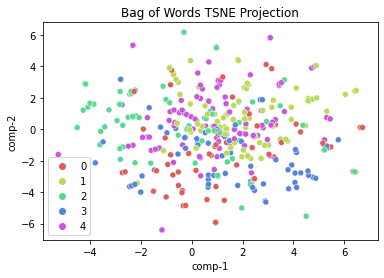

In [194]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_train)
df_plot = pd.DataFrame()
df_plot["y"] = y_train
df_plot["comp-1"] = z[:,0]
df_plot["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_plot.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df_plot).set(title="Bag of Words TSNE Projection")

In [195]:
### SVC classifier
SVMC = SVC(probability=True, kernel='rbf')
#Fitting the model
SVMC.fit(x_train,y_train)

SVC(probability=True)

In [196]:
pred = SVMC.predict(x_test)
pred2 = SVMC.predict_proba(x_test)[:, 1]

acc = accuracy_score(y_test,pred)
bal_acc = balanced_accuracy_score(y_test, pred)
print(acc, bal_acc)

0.5343511450381679 0.4881807968196353


## Word2Vec

As features obtidas anteriormente utilizando bag of words não foram tão eficazes para alimentar o modelo. Vamos verificar se é possível melhorar o desempenho do classificador por meio de vetores do tipo Word2Vec. Esses vetores carregam informação contextual, e por isso é esperado que essa abordagem leve a melhores resultados. Para que cada "sentence" seja representado por um único vetor, vamos calcular o vetor médio de cada frase: tomam-se os vetores de cada palavra em uma frase, tomando o cuidado de verificar se a palavra em questão pertence ao modelo pré-treinado, e calcula-se a média entre eles.

Como modelo pré-treinado, é utilizado um Word2Vec treinado com a técnica skip gram em um corpus de língua portuguesa. O arquivo pode ser obtido em http://www.nilc.icmc.usp.br/embeddings (acesso em 29/09/2022)

In [197]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("/home/joao/Desktop/hand_talk/sent_class/skip_s50.txt")

In [198]:
model.most_similar("projeto")

[('cronograma', 0.7738995552062988),
 ('anteprojeto', 0.7688136696815491),
 ('programa', 0.7492717504501343),
 ('plano', 0.749216616153717),
 ('substitutivo', 0.7378090620040894),
 ('amrt', 0.7197443842887878),
 ('organograma', 0.7095134854316711),
 ('tombamento', 0.7055686712265015),
 ('escopo', 0.6999985575675964),
 ('worldforge', 0.6952257752418518)]

In [199]:
def avg_vector(df):
    vectors = []
    for sentence in df.sentence.values:
        words = sentence.split(' ')
        words = [w for w in words if w in model]
        mean_vec = np.average(model[words], axis = 0)
        vectors.append(mean_vec)
    return np.array(vectors)

In [200]:
x_train = avg_vector(train)
x_test = avg_vector(test)

In [201]:
x_train.shape

(390, 50)

In [202]:
### SVC classifier
SVMC = SVC(probability=True, kernel='rbf')
#Fitting the model
SVMC.fit(x_train,y_train)

SVC(probability=True)

In [203]:
pred = SVMC.predict(x_test)
pred2 = SVMC.predict_proba(x_test)[:, 1]

acc = accuracy_score(y_test,pred)
bal_acc = balanced_accuracy_score(y_test, pred)
print(acc, bal_acc)

0.648854961832061 0.6400112349840118


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 390 samples in 0.001s...
[t-SNE] Computed neighbors for 390 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 0.406795
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.823837
[t-SNE] KL divergence after 1000 iterations: 1.122077


[Text(0.5, 1.0, 'Word2Vec TSNE Projection')]

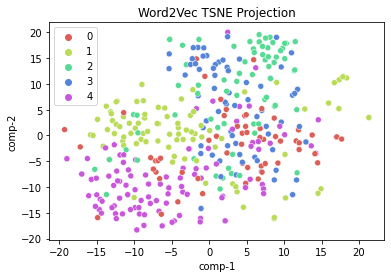

In [204]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_train)
df_plot = pd.DataFrame()
df_plot["y"] = y_train
df_plot["comp-1"] = z[:,0]
df_plot["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_plot.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df_plot).set(title="Word2Vec TSNE Projection")

# Transformers 

In [235]:
from transformers import BertTokenizer
import torch
from torch import nn
from torch.optim import Adam, SGD

In [207]:
bertimbau = 'neuralmind/bert-base-portuguese-cased'

In [208]:
tokenizer = BertTokenizer.from_pretrained(bertimbau)

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [209]:
teste = "Eu quero trabalhar na Hand Talk"

In [211]:
bert_input = tokenizer(teste, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,  3396, 18691,  3212,   229, 18041,  3864, 22331,   102,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])


In [215]:
teste_input = tokenizer.decode(bert_input.input_ids[0])

print(teste_input)

[CLS] Eu quero trabalhar na Hand Talk [SEP] [PAD]


In [216]:
labels = class2id

In [220]:
lengths = [len(l) for l in df.sentence]
print(np.mean(lengths))

51.03262955854127


(array([ 20.,  95., 100., 116.,  76.,  57.,  36.,  14.,   2.,   5.]),
 array([  2. ,  15.6,  29.2,  42.8,  56.4,  70. ,  83.6,  97.2, 110.8,
        124.4, 138. ]),
 <BarContainer object of 10 artists>)

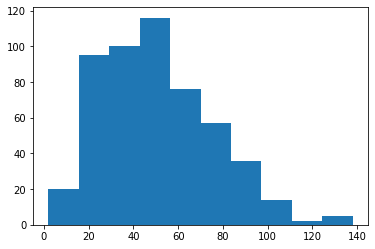

In [228]:
plt.hist(lengths)

In [256]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 50, truncation=True,
                                return_tensors="pt") for text in df['sentence']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [257]:
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5, num_classes = 5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bertimbau)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [268]:
from tqdm import tqdm
def train_bertimbau(model, train_data, learning_rate, epochs):

    train = Dataset(train_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f}')

In [273]:
EPOCHS = 10
model = BertClassifier()
LR = 1e-6
              
train_bertimbau(model, train, LR, EPOCHS)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 195/195 [02:33<00:00,  1.27it/s]


Epochs: 1 | Train Loss:  0.807                 | Train Accuracy:  0.205


100%|██████████| 195/195 [02:36<00:00,  1.25it/s]


Epochs: 2 | Train Loss:  0.787                 | Train Accuracy:  0.318


100%|██████████| 195/195 [02:35<00:00,  1.25it/s]


Epochs: 3 | Train Loss:  0.764                 | Train Accuracy:  0.405


100%|██████████| 195/195 [02:37<00:00,  1.24it/s]


Epochs: 4 | Train Loss:  0.729                 | Train Accuracy:  0.531


100%|██████████| 195/195 [02:32<00:00,  1.28it/s]


Epochs: 5 | Train Loss:  0.679                 | Train Accuracy:  0.603


100%|██████████| 195/195 [02:38<00:00,  1.23it/s]


Epochs: 6 | Train Loss:  0.614                 | Train Accuracy:  0.728


100%|██████████| 195/195 [02:30<00:00,  1.29it/s]


Epochs: 7 | Train Loss:  0.549                 | Train Accuracy:  0.759


100%|██████████| 195/195 [02:26<00:00,  1.33it/s]


Epochs: 8 | Train Loss:  0.486                 | Train Accuracy:  0.828


100%|██████████| 195/195 [02:27<00:00,  1.33it/s]


Epochs: 9 | Train Loss:  0.420                 | Train Accuracy:  0.862


100%|██████████| 195/195 [02:33<00:00,  1.27it/s]

Epochs: 10 | Train Loss:  0.362                 | Train Accuracy:  0.913


In [274]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    


In [275]:
evaluate(model, test)

Test Accuracy:  0.817
